In [51]:
import numpy as np
import copy
import pandas as pd
import sys
sys.path.insert(0,'../')
from gym_ur.game_of_ur2 import GoUrEnv
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.cm as cm
import dill
import os.path
plt.style.use('ggplot')

In [52]:
def eGreedyActionSelection(env, q_curr, eps, possible_actions, movable_piece_board_pos):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        env: Environment
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''
    if np.random.rand() < (1 - eps):
        best_val = np.max(q_curr)
        b_actions=np.arange(q_curr.size, dtype=int)[q_curr==best_val]
        best_action = np.random.choice(b_actions)
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

In [53]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p)

In [54]:
env = GoUrEnv(4)

In [55]:
def get_probabilities(state, Q, env, eps):
    prob = np.ones(env.action_space_n, dtype=float) * eps / env.action_space_n
    action = np.argmax(Q[state])
    prob[action] += (1.0 - eps)
    return prob
    
def expected_sarsa(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200):
    '''
    Q-learning algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    init_q_value = 0.0
    Q = defaultdict(lambda: np.ones(env.action_space_n) * init_q_value)
    episode_rewards_p1 = np.zeros(num_episodes-1)
    episode_rewards_p2 = np.zeros(num_episodes-1)
    episode_lengths = np.zeros(num_episodes-1)
    player1 = 0
    player2 = 1
    time_to_win = []
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)
    
    for i in range(num_episodes-1):
        dice_up = env.roll()
        state = env.reset(dice_up)
        t = 1
        while True:
            episode_lengths[i] = t
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                episode_rewards_p1[i] += reward_p1
            
                prob = get_probabilities(new_state, Q, env, exploration.value(i))
                Q[state][action['board_pos']] += alpha * (reward_p1 + (gamma*(np.sum(prob*Q[new_state]))) 
                                                            - Q[state][action['board_pos']])
            
                if done:
                    break
                    
                state = new_state
                
             # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            if len(possible_actions) != 0:
                action = eGreedyActionSelection(env, Q[state], exploration.value(i), possible_actions, movable_piece_board_pos)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_rewards_p2[i] += reward_p2
            
                prob = get_probabilities(new_state, Q, env, exploration.value(i))
                Q[state][action['board_pos']] += alpha * (reward_p2 + (gamma*(np.sum(prob*Q[new_state]))) 
                                                            - Q[state][action['board_pos']])
            
                if done:
                    break
                    
                # player 1 move
                dice_up = env.roll()
                    
                state = new_state
            t += 1
        time_to_win.append(t)
    return Q, episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win

In [56]:
episode_rwds_p1 = []
episode_rwds_p2 = []
total_episodes = 100000
# dir_path = 'TD/pickels/eSarsa'
# runs
    
# train agent
q_func_1, episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win = expected_sarsa(env, total_episodes)

# append rewards for each run
episode_rwds_p1.append(episode_rewards_p1)
episode_rwds_p2.append(episode_rewards_p2)

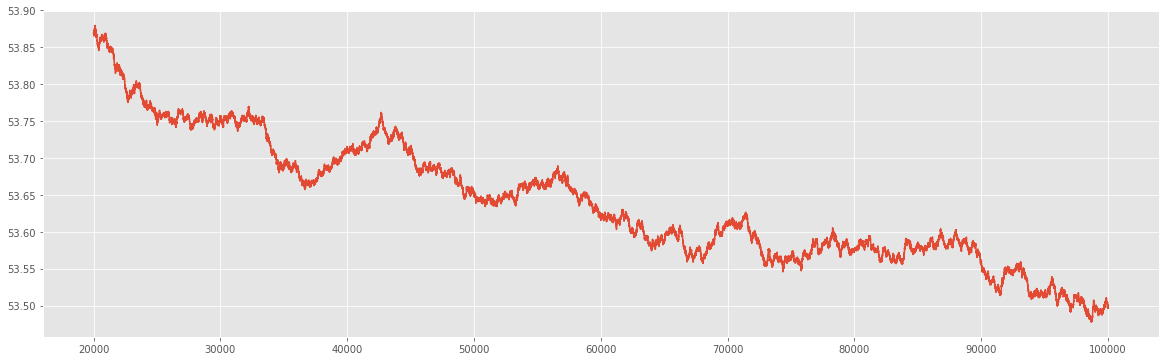

In [57]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(time_to_win).rolling(20000, min_periods=20000).mean())

In [73]:
print(time_to_win)

[50, 47, 67, 56, 44, 47, 51, 52, 50, 58, 63, 50, 64, 44, 50, 43, 58, 56, 51, 54, 57, 50, 62, 55, 65, 57, 55, 59, 78, 55, 70, 49, 49, 58, 60, 64, 41, 62, 50, 48, 41, 49, 46, 61, 52, 51, 66, 45, 47, 57, 45, 49, 40, 40, 50, 52, 50, 54, 55, 52, 54, 44, 62, 59, 43, 67, 42, 43, 43, 64, 55, 49, 43, 57, 41, 57, 48, 50, 54, 50, 44, 42, 61, 51, 62, 48, 56, 57, 45, 58, 60, 56, 62, 48, 39, 58, 59, 55, 44, 70, 39, 48, 55, 59, 42, 52, 46, 41, 45, 58, 52, 45, 55, 43, 59, 55, 40, 56, 78, 46, 65, 60, 50, 53, 54, 60, 57, 67, 56, 67, 62, 53, 47, 60, 55, 62, 71, 42, 52, 51, 52, 73, 78, 51, 74, 51, 50, 36, 55, 49, 61, 66, 65, 44, 44, 65, 62, 74, 57, 40, 43, 53, 69, 50, 51, 45, 45, 48, 57, 72, 62, 57, 50, 49, 57, 72, 66, 52, 62, 53, 56, 40, 80, 80, 48, 40, 59, 56, 57, 54, 66, 64, 51, 59, 54, 56, 60, 52, 58, 48, 63, 47, 56, 69, 48, 39, 48, 49, 55, 47, 66, 52, 50, 62, 62, 49, 58, 56, 53, 54, 55, 54, 64, 58, 48, 47, 42, 52, 51, 43, 44, 48, 42, 57, 53, 52, 46, 44, 52, 56, 49, 43, 49, 60, 61, 54, 49, 46, 50, 51,

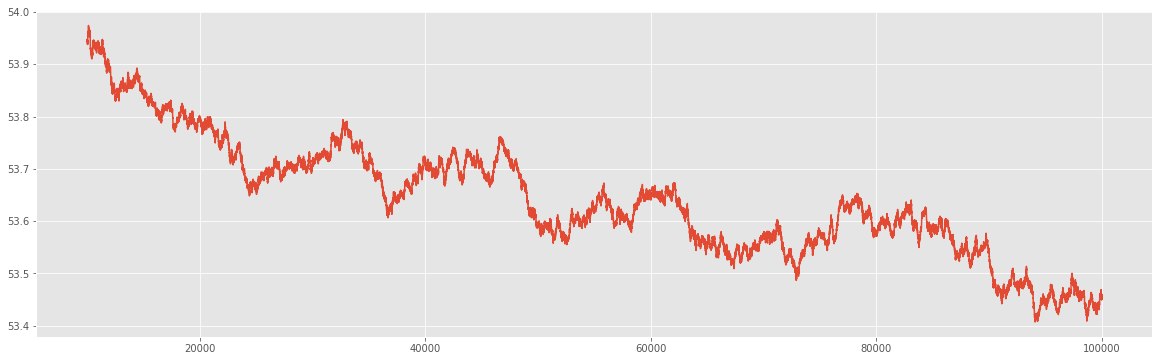

In [58]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(episode_lengths).rolling(10000, min_periods=10000).mean())

In [59]:
# get policy
policy = {}
for key, value in q_func_1.items():
    policy[key] = np.argmax(value)

In [60]:
def random_policy(possible_actions):
    return np.random.choice(possible_actions)

def trained_policy(state, possible_actions, policy, movable_piece_board_pos):
    if state in policy:
        best_action = policy[state]
        if best_action in movable_piece_board_pos.keys():
            return movable_piece_board_pos[best_action]
        
    return np.random.choice(possible_actions)

def test_q_agent(env, num_episodes, policy):
    player1 = 0 # trained
    player2 = 1 # random
    init_q_value = 0.0
    
    episode_rewards_p1 = np.zeros(num_episodes)
    episode_rewards_p2 = np.zeros(num_episodes)
    time_to_win = []
    for i in range(num_episodes):
        episode_transitions_p1 = list()
        episode_transitions_p2 = list()
        dice_up = env.roll()
        state = env.reset(dice_up)
        is_done = False
        t = 0
        
        while True:
            # player 1 move
            t += 1
            
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player1, dice_up)
            reward_p1 = 0
            if len(possible_actions) != 0:
                action = trained_policy(state, possible_actions, policy, movable_piece_board_pos)
                new_state, reward_p1, done, _ = env.step(action, dice_up)
                episode_rewards_p1[i] += reward_p1
                state = copy.deepcopy(new_state)
                
                if done:
                    break
           
            # player 2 move
            dice_up = env.roll()
            possible_actions, movable_piece_ids, movable_piece_board_pos = env.get_possible_actions(player2, dice_up)
            reward_p2 = 0
            if len(possible_actions) != 0:
                action = random_policy(possible_actions)
                new_state, reward_p2, done, _ = env.step(action, dice_up)
                episode_rewards_p2[i] += reward_p2
                state = copy.deepcopy(new_state)

                if done:
                    break
            
            dice_up = env.roll()
        time_to_win.append(t)
        
    return episode_rewards_p1, episode_rewards_p2, episode_lengths, time_to_win

In [61]:
test_episode_rewards_p1, test_episode_rewards_p2, test_episode_lengths, test_time_to_win = test_q_agent(env, 100, policy)

In [62]:
test_avg_trained = np.mean(test_episode_rewards_p1)
test_avg_random = np.mean(test_episode_rewards_p2)
print("Trained Score: ", test_avg_trained/(test_avg_random + test_avg_trained))
print("Random Score: ", test_avg_random/(test_avg_random + test_avg_trained))

Trained Score:  0.5449346897008367
Random Score:  0.4550653102991633


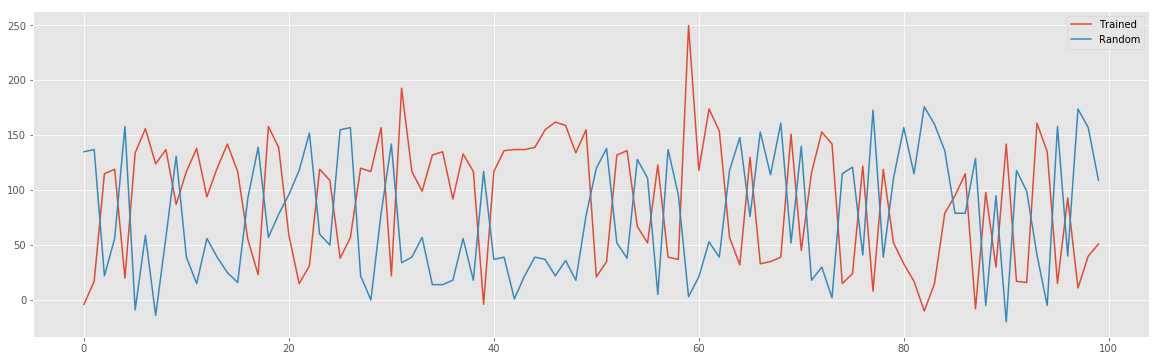

In [63]:
plt.figure(figsize=(20, 6))
trained, = plt.plot(test_episode_rewards_p1[:100], label='Trained')
random, = plt.plot(test_episode_rewards_p2[:100], label='Random')
plt.legend([trained, random], ['Trained', 'Random'])

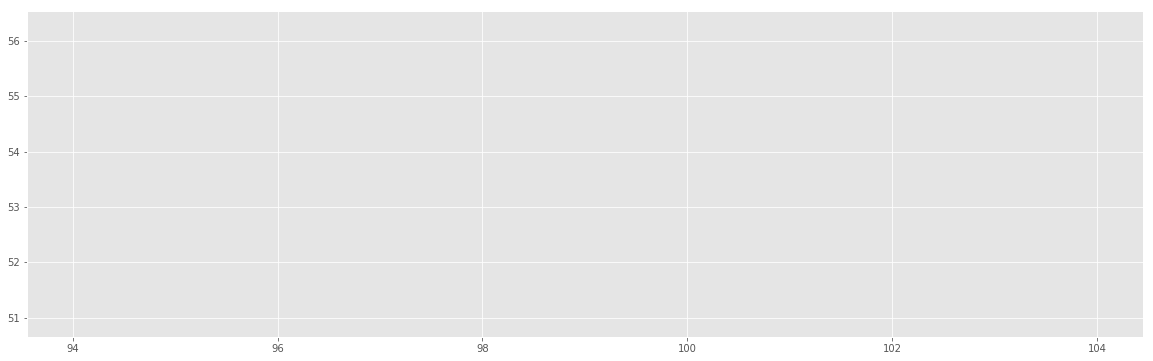

In [64]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(test_time_to_win).rolling(100, min_periods=100).mean())

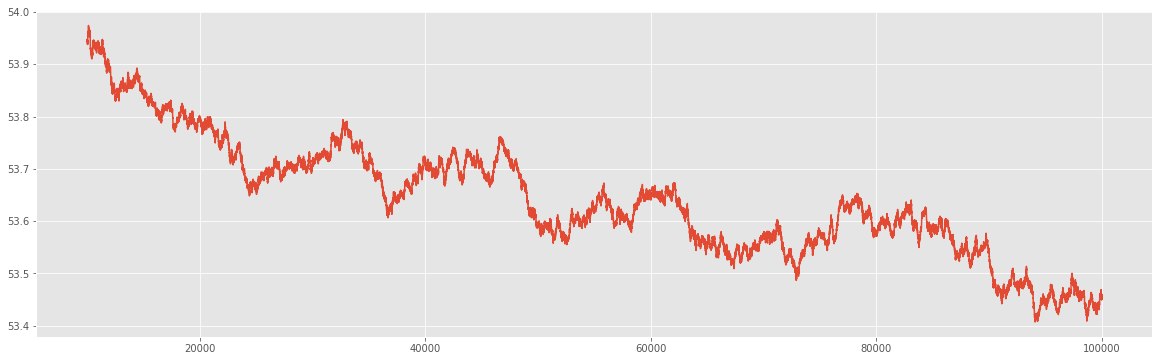

In [65]:
plt.figure(figsize=(20, 6))
plt.plot(pd.Series(test_episode_lengths).rolling(10000, min_periods=10000).mean())

In [66]:
# p1_mean_rwds = np.mean(np.array(episode_rwds_p1[-1]).reshape(1, -1), axis=0)
# p2_mean_rwds = np.mean(np.array(episode_rwds_p2[-1]).reshape(1, -1), axis=0)

In [67]:
# plt.figure(figsize=(20, 6))
# plt.plot(p1_mean_rwds[-100:])

In [68]:
# plt.figure(figsize=(20, 6))
# plt.plot(p2_mean_rwds[-100:])

In [69]:
# plt.figure(figsize=(20, 6))
# plt.plot(p1_mean_rwds[-100:])
# plt.plot(p2_mean_rwds[-100:])

In [70]:
# plt.figure(figsize=(20, 6))
# plt.plot(pd.Series(p1_mean_rwds).rolling(1000, min_periods=1000).mean())

In [71]:
# plt.figure(figsize=(20, 6))
# plt.plot(pd.Series(p2_mean_rwds).rolling(1000, min_periods=1000).mean())

In [72]:
# plt.figure(figsize=(20, 6))
# plt.plot(pd.Series(p1_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())
# plt.plot(pd.Series(p2_mean_rwds[-1000:]).rolling(100, min_periods=100).mean())